# Ground Truth 



* **Last Modified**: 17-03-2022
* **Authors**: Satyarth Praveen, J. Emmanuel Johnson, Nadia Ahmed, Gonzalo Mateo-García
---
#### Brief Description

In this notebook, we will explore how to visualize the different products that we use in the *WorldFloods* dataset. In addition we will show how to create the ground truth that we used for training the models (the 3-class ground truth used in [Mateo-García et al. 2021](https://www.nature.com/articles/s41598-021-86650-z) and the new binary ground truth for multi-output binary classification). 

This tutorial follows the previous one about [ingesting floodmaps](./prep/full_data_ingest.ipynb) which shows how to pre-process and download floodmaps and how to download Sentinel-2 images using the Google Earth Engine. In this notebook we use these products (floodmaps, S2 images and JRC Permanent Water Layer also downlinked from the GEE).


To create the ground truth necessary in the *WorldFloods* data, we need access to water layers, clouds. So let's show how we do this!

---

In [1]:
!pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

  Cloning https://github.com/spaceml-org/ml4floods to /tmp/pip-install-1ocx6bq9/ml4floods_047e23a821dc4d3f90c1cd136315a242
  Running command git clone --filter=blob:none --quiet https://github.com/spaceml-org/ml4floods /tmp/pip-install-1ocx6bq9/ml4floods_047e23a821dc4d3f90c1cd136315a242
  Resolved https://github.com/spaceml-org/ml4floods to commit a2f4f6df8b79cc641572ba6fa5287b9a68c67505
  Preparing metadata (setup.py) ... done
  Created wheel for ml4floods: filename=ml4floods-0.0.1-py3-none-any.whl size=140086 sha256=1be823c64a228fb0acf7e481c084b4a16d994c1aecfa9e94750c0d11eb3f8700
  Stored in directory: /tmp/pip-ephem-wheel-cache-rvlnv79q/wheels/73/e4/d0/32f1ac519c0c417c56095146587858a3e35491dbbef7d45186
Successfully built ml4floods
  Attempting uninstall: ml4floods
    Found existing installation: ml4floods 0.0.1
    Uninstalling ml4floods-0.0.1:
      Successfully uninstalled ml4floods-0.0.1


## Step 0: Access the data for this tutorial

In order to run this tutorial we will use some products from the forthcoming *WorldFloods Extra Dataset*. We have copied some of those in our [public Google Drive folder](https://drive.google.com/folderview?id=1dqFYWetX614r49kuVE3CbZwVO6qHvRVH). To access the *WorldFloods* database see [the download *WorldFloods* documentation](./worldfloods_dataset.md). 

## Step 0a: mount the Public folder if you are in Google Colab
If you're running this tutorial in Google Colab you need to *‘add a shortcut to your Google Drive’* from the [public Google Drive folder](https://drive.google.com/folderview?id=1dqFYWetX614r49kuVE3CbZwVO6qHvRVH) and mount that directory with the following code:

In [1]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    assert os.path.exists('/content/drive/My Drive/Public WorldFloods Dataset'), "Add a shortcut to the publice Google Drive folder: https://drive.google.com/drive/u/0/folders/1dqFYWetX614r49kuVE3CbZwVO6qHvRVH"
    google_colab = True
    path_to_dataset_folder = '/content/drive/My Drive/Public WorldFloods Dataset'
except ImportError as e:
    print(e)
    print("Setting google colab to false, it will need to install the gdown package!")
    path_to_dataset_folder = "."
    google_colab = False

No module named 'google.colab'
Setting google colab to false, it will need to install the gdown package!


If you're not in Google Colab you need to install the `gdown` package to access the products. `pip install gdown`.

## Original Image

Let's load a demo Sentinel-2 (S2) image which will be the basis for all of our demonstrations.

In [2]:
import gdown
import os

# S2_IMG_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/EMSR501/AOI01/S2/2021-02-15.tif"

S2_IMG_PATH = os.path.join(path_to_dataset_folder, "products_sample_tutorial","S2", "2021-02-15.tif")
if not os.path.exists(S2_IMG_PATH): 
    import gdown
    os.makedirs(os.path.dirname(S2_IMG_PATH), exist_ok=True)
    gdown.download(id="1wPxBASA5KaEiKPyU78ryzSHjEuZaLYEL", output=S2_IMG_PATH)

Downloading...
From: https://drive.google.com/uc?id=1wPxBASA5KaEiKPyU78ryzSHjEuZaLYEL
To: /home/gonzalo/git/ml4floods/jupyterbook/content/prep/products_sample_tutorial/S2/2021-02-15.tif
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560M/560M [00:08<00:00, 67.8MB/s]


## Demo Plot

We have an easy plot function to visualize the S2 image. 

[Text(0.5, 1.0, 'Demo Sentinel-2 Image')]

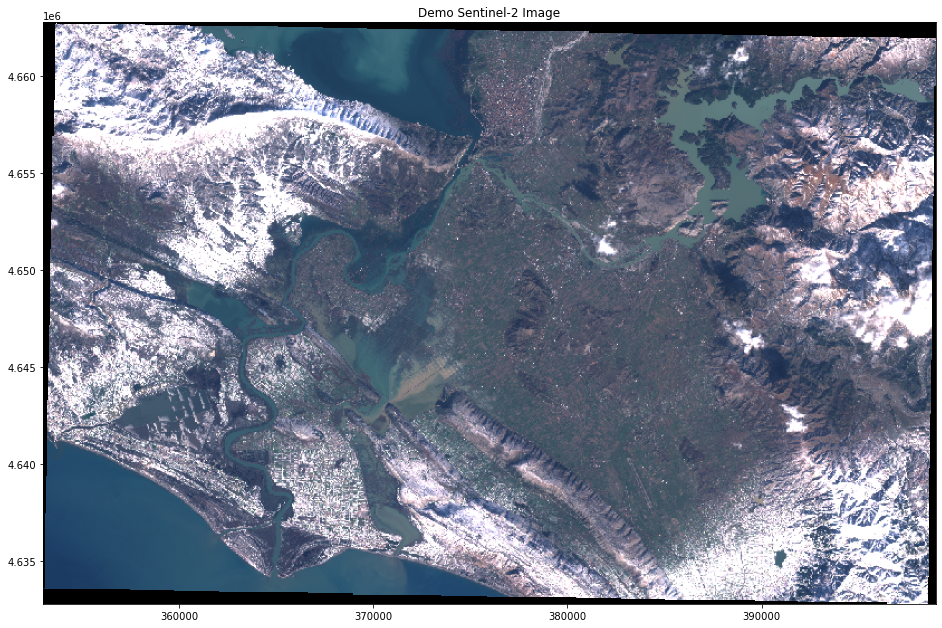

In [3]:
from ml4floods.visualization import plot_utils
from rasterio import plot as rasterioplt
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# initialize figure
fig, ax = plt.subplots(figsize=(16,16))

plot_utils.plot_rgb_image(S2_IMG_PATH, ax=ax, size_read=800)

ax.set(
    title="Demo Sentinel-2 Image",
)

This is mainly for demonstration purposes. For more advanced plotting utilities, please consult a specialized library. 

So now we have our image, let's see what tools we have available to do masks. 

## Cloud Masks

### Last Channel Cloud Probabilities

Fortunately for some of the newer S2 images obtained from GEE, we can simply use the final channel.

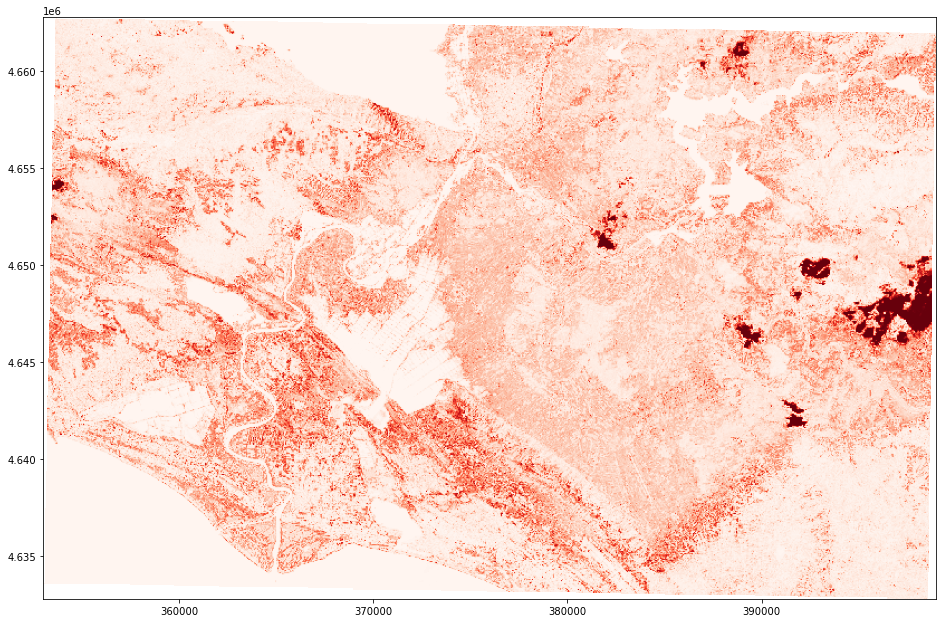

[Text(0.5, 1.0, 'Cloud Probabilities')]

In [4]:

image, transform = plot_utils.get_image_transform(S2_IMG_PATH, bands=[14], 
                                                  size_read=800)



# initialize figure
fig, ax = plt.subplots(figsize=(16,16))

# plot image
rasterioplt.show(image[0],transform=transform, vmin=0,vmax=100, cmap="Reds")

ax.set(
    title="Cloud Probabilities",
)

### Model-Based

In other cases where this is not available, we can also use models on the original image. One method that we use within this library is called `s2cloudless`, found [here](https://github.com/sentinel-hub/sentinel2-cloud-detector). This is a model from the sentinel-hub which has a very convenient API for our uses. See [this blog](https://medium.com/sentinel-hub/improving-cloud-detection-with-machine-learning-c09dc5d7cf13) for more details.

Below, we showcase how we can return cloudmasks in a single function within this library. 

**Warnings**: This will take a while to run. Please skip over the section to resume the tutorial.

In [4]:
# %%time
# from src.data.cloud_masks import compute_s2cloudless_probs

# # calculate cloud probabilities using cloudless
# s2_cloud_probs = compute_s2cloudless_probs(S2_IMG_PATH)

#### Figure

In [5]:
# fig, ax = plt.subplots(figsize=(16,16))

# with rasterio.open(S2_IMG_PATH, "r") as s2_rst:
#     transform = s2_rst.transform

# rasterioplt.show(s2_cloud_probs, ax=ax, transform=transform, cmap="Reds")

# ax.set(
#     title="S2CloudLess Cloud Probabilities",
# )
# plt.show()

**Note**: This is actually the same library that is used within the GEE platform! See [this tutorial](https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless) for more information.

## Water Masks

### Permanent Water

So firstly, we have the permanent water. These are streams, rivers and lakes that already exist. This serves as a basis for where the flood events *could* occur.

In [5]:
# permanent water
# JRC_IMG_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/EMSR501/AOI01/PERMANENTWATERJRC/2021.tif"

JRC_IMG_PATH = os.path.join(path_to_dataset_folder, "products_sample_tutorial","PERMANENTWATERJRC", "2021.tif")
if not os.path.exists(JRC_IMG_PATH):
    os.makedirs(os.path.dirname(JRC_IMG_PATH), exist_ok=True)
    gdown.download(id="1N_NF9xdO4Qse2Bp76t0sZHrOO24fd-xt", output=JRC_IMG_PATH)

Downloading...
From: https://drive.google.com/uc?id=1N_NF9xdO4Qse2Bp76t0sZHrOO24fd-xt
To: /home/gonzalo/git/ml4floods/jupyterbook/content/prep/products_sample_tutorial/PERMANENTWATERJRC/2021.tif
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 314k/314k [00:00<00:00, 4.19MB/s]


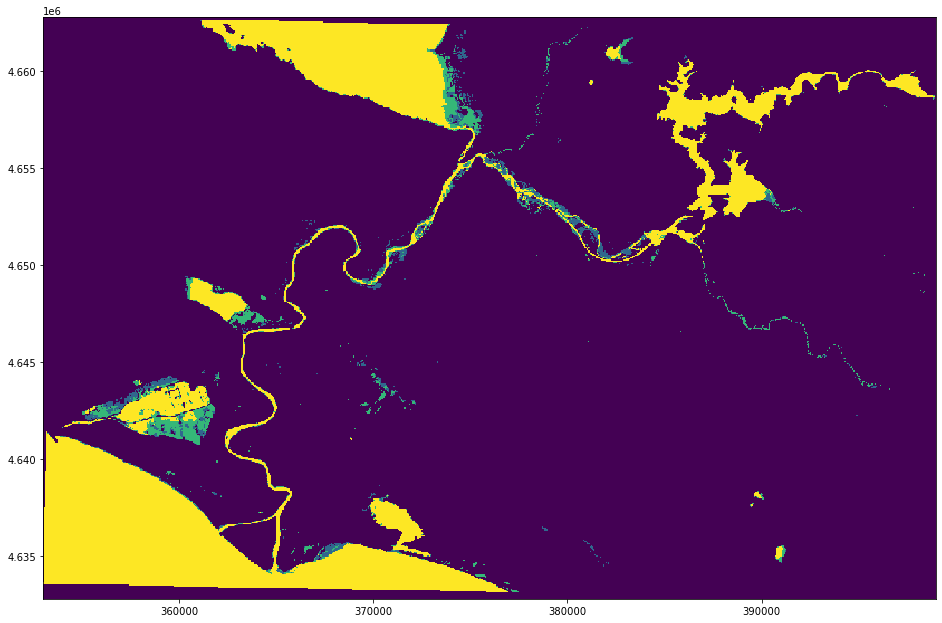

In [6]:
permanent_water_image, transform = plot_utils.get_image_transform(JRC_IMG_PATH, bands=[0], 
                                                                  size_read=800)

# initialize figure
fig, ax = plt.subplots(figsize=(16,16))

rasterioplt.show(permanent_water_image[0],transform=transform, vmin=0,vmax=3, interpolation='nearest')

ax.set(
    title="Permanent Water",
)
plt.show()

### Flood Events

We need the flood events. These come from the Copernicus EMS data source where we have already preprocessed them to extract the necessary information for floods. These come in the form of `geojson` files which keep all of the polygons indicating the specific coordinates where there was a drought. We can easily read it with the `geopandas` package.

In [7]:
# FLOODMAP_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/EMSR501/AOI01/floodmap/2021-02-15.geojson"
FLOODMAP_PATH = os.path.join(path_to_dataset_folder, "products_sample_tutorial", "floodmap", "2021-02-15.geojson")

if not os.path.exists(FLOODMAP_PATH):
    os.makedirs(os.path.dirname(FLOODMAP_PATH), exist_ok=True)
    gdown.download(id="1GS1_9fXwrYdgu7o-0RU4I8ixch4pVpQC", output=FLOODMAP_PATH)
    

Downloading...
From: https://drive.google.com/uc?id=1GS1_9fXwrYdgu7o-0RU4I8ixch4pVpQC
To: /home/gonzalo/git/ml4floods/jupyterbook/content/prep/products_sample_tutorial/floodmap/2021-02-15.geojson
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11.9M/11.9M [00:00<00:00, 35.4MB/s]


In [8]:
import geopandas as gpd

floodmap_df = gpd.read_file(FLOODMAP_PATH)

In [9]:
floodmap_df[floodmap_df["w_class"] == "Flooded area"]

w_class source                                           geometry
0     Flooded area  flood  MULTIPOLYGON (((19.48718 42.09541, 19.48706 42...
1     Flooded area  flood  POLYGON ((19.48966 42.09551, 19.48966 42.09540...
2     Flooded area  flood  POLYGON ((19.48887 42.09549, 19.48887 42.09547...
3     Flooded area  flood  POLYGON ((19.48967 42.09486, 19.48967 42.09481...
4     Flooded area  flood  POLYGON ((19.48731 42.09523, 19.48731 42.09518...
...            ...    ...                                                ...
2046  Flooded area  flood  POLYGON ((19.43283 41.90527, 19.43283 41.90518...
2047  Flooded area  flood  POLYGON ((19.43063 41.90832, 19.43064 41.90823...
2048  Flooded area  flood  POLYGON ((19.43015 41.90893, 19.43015 41.90884...
2049  Flooded area  flood  POLYGON ((19.43065 41.90295, 19.43064 41.90304...
2050  Flooded area  flood  POLYGON ((19.42929 41.91042, 19.42929 41.91033...

[2051 rows x 3 columns]

In [10]:
floodmap_df["w_class"].unique()

array(['Flooded area', 'BH080-Lake', 'BH130-Reservoir', 'BH140-River',
       'BH141-River Bank', 'BA040-Open Water', 'BH141-Stream',
       'BA010-Coastline', 'area_of_interest'], dtype=object)

That's it! We can also plot this just to get an overview of the polygons available. Remember the last polygon is the area of interest, so plot all except that one.

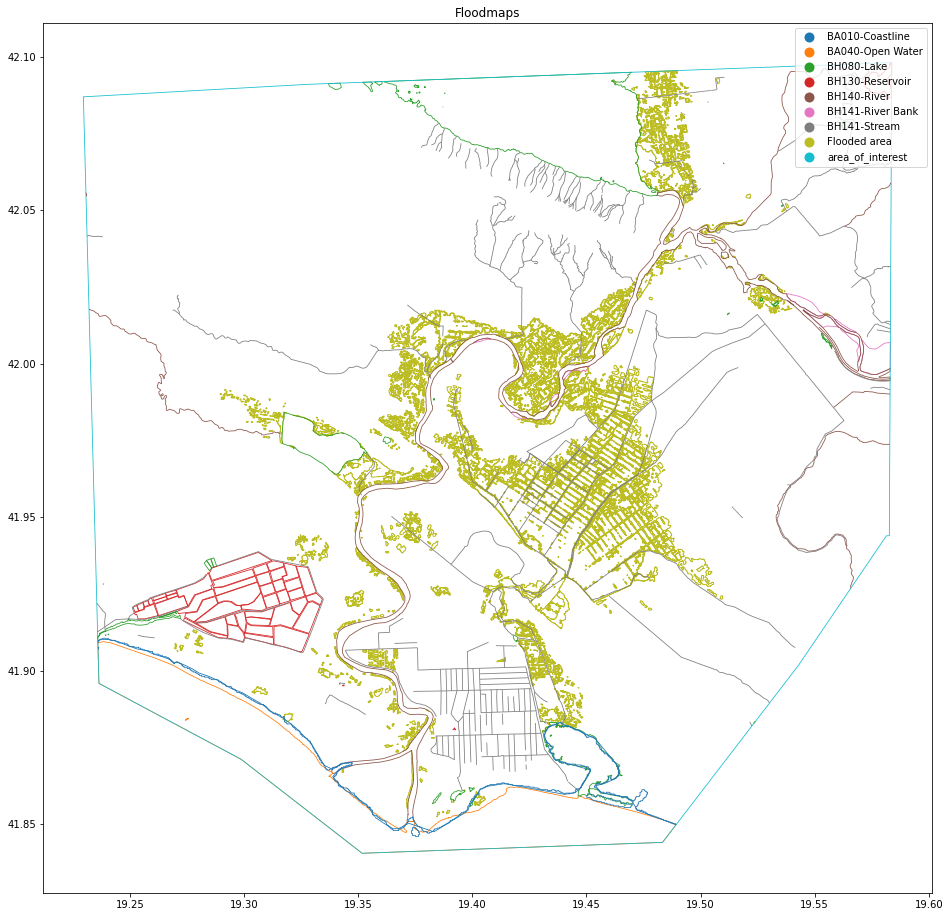

In [11]:

# initialize figure
fig, ax = plt.subplots(figsize=(16,16))

floodmap_df.plot("w_class", ax=ax, facecolor="None", label="Flood Maps", linewidth=0.8,
                 legend=True)

ax.set(
    title="Floodmaps"
)
plt.show()

#### Plot - FloodMaps On Permanent Water

We can also plot the floodmaps on the permanent water to get an overview of how much these flood maps overlap with the already placed permanent water areas.

<AxesSubplot:>

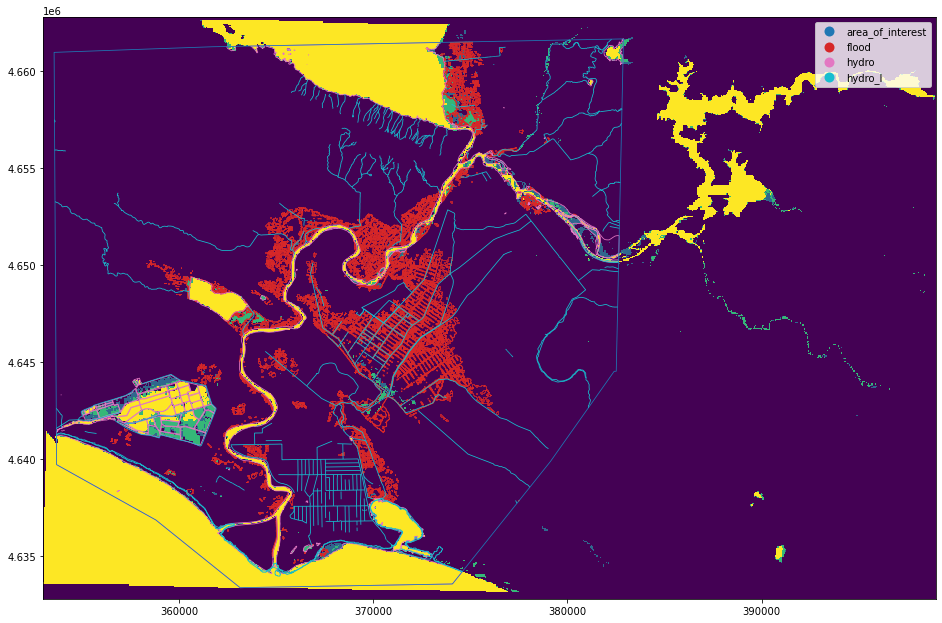

In [12]:
# initialize figure

fig, ax = plt.subplots(figsize=(16,16))

# plot the permanent water
rasterioplt.show(permanent_water_image[0],transform=transform, vmin=0, vmax=3, interpolation='nearest', ax=ax)

# plot the floodmap (convert to same CRS the floodmap!)
with rasterio.open(JRC_IMG_PATH) as src:
    floodmap_df_utm = floodmap_df.to_crs(src.crs)

floodmap_df_utm.plot("source", ax=ax, facecolor="None", label="Flood Maps", linewidth=0.8, 
                     legend=True)

So we can see that it's very clear that there is some overlap between the permanent water and the flood maps, but there are also many areas that extend beyond the standard region.

#### Figure - FloodMaps On S2 Image

We can actually overlay the floodmaps onto the S2 Image. Because all of the geocoordinates are consistent, this allows us to visualize all of the pieces together.

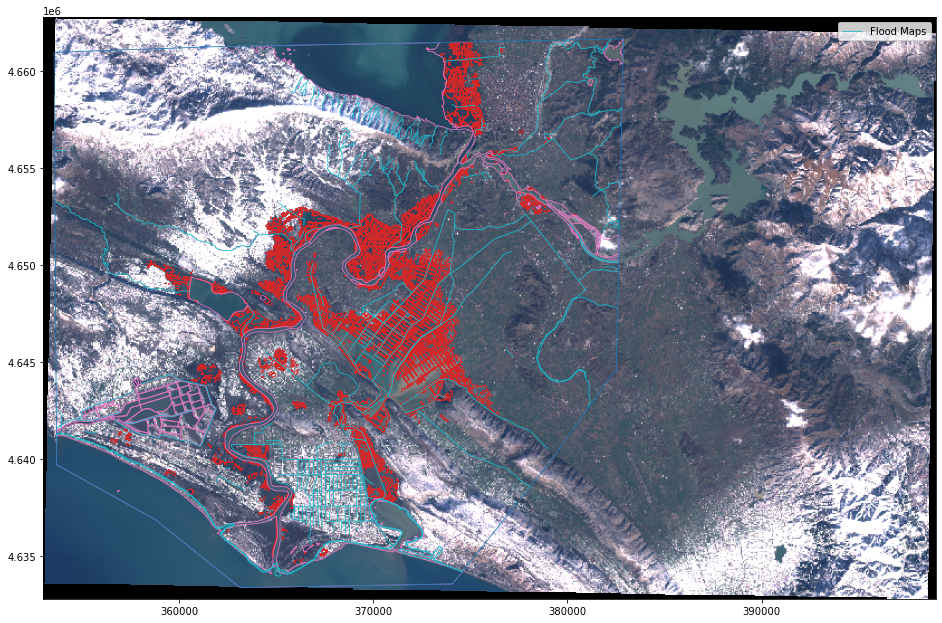

In [13]:
# initialize figure
fig, ax = plt.subplots(figsize=(16,16))

# plot S2 Image
plot_utils.plot_rgb_image(S2_IMG_PATH, ax=ax, size_read=800, label="S2 Image")

# plot the floodmap
floodmap_df_utm.plot("source", ax=ax, facecolor="None", label="Flood Maps", linewidth=0.8, 
                     legend=True)

plt.legend()
plt.show()

## Ground Truth

So now we've seen all of the bits and pieces needed to get the data required to create the ground truth: 1) S2 Image, 2) Cloud Masks, 3) FloodMaps, 4) Permanent Water. We can now create some ground truth images which can be used for our machine learning problem.

### 3-Class Problem

This first ground truth type is a 3-class problem: Land, Water, Cloud. We basically fuse these four resources together to create the ground truth. So a simple logistic regression model would be able to use this. However, it would probably do poorly due to the complexity of the data.

It's very simple to generate ground truth with the functions we created.

In [14]:
from ml4floods.data import create_gt

In [15]:
%%time

# Might need to run again if the code breaks.

metadata_floodmap = {}

gt, gt_meta = create_gt.generate_land_water_cloud_gt(                      
    S2_IMG_PATH,
    floodmap_df,
    metadata_floodmap,
    keep_streams=True,
    permanent_water_image_path=JRC_IMG_PATH
)

CPU times: user 13.4 s, sys: 8.25 s, total: 21.7 s
Wall time: 24.3 s


In [16]:
gt_meta

{'gtversion': 'v1',
 'encoding_values': {0: 'invalid', 1: 'land', 2: 'water', 3: 'cloud'},
 'shape': [2996, 4597],
 's2_image_path': '2021-02-15.tif',
 'permanent_water_image_path': '2021.tif',
 'cloudprob_image_path': 'None',
 'method clouds': 's2cloudless',
 'pixels invalid S2': 6472757,
 'pixels clouds S2': 250244,
 'pixels water S2': 1559933,
 'pixels land S2': 5489678,
 'pixels flood water S2': 561790,
 'pixels hydro water S2': 212124,
 'pixels permanent water S2': 786019,
 'bounds': BoundingBox(left=353000.0, bottom=4632790.0, right=398970.0, top=4662750.0),
 'crs': CRS.from_epsg(32634),
 'transform': Affine(10.0, 0.0, 353000.0,
        0.0, -10.0, 4662750.0)}

### Show 3-class ground truth

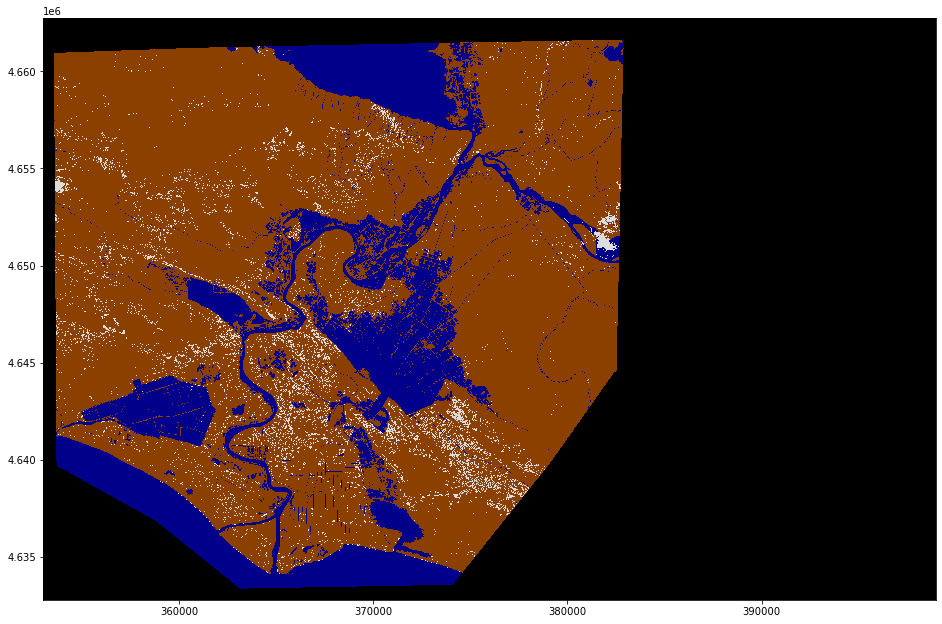

<AxesSubplot:>

In [17]:
fig, ax = plt.subplots(figsize=(16,16))

plot_utils.plot_gt_v1(gt[np.newaxis], transform=gt_meta["transform"])

## 2-Class Problem

In this ground truth, we generate 2-band ground truth. This ground truth can be used to train a multioutput binary segmentation model.

In [18]:
from ml4floods.data import create_gt

In [19]:
%%time

# Might need to run again if the code breaks.

metadata_floodmap = {}

gt_binary, gt_meta_binary = create_gt.generate_water_cloud_binary_gt(                        
    S2_IMG_PATH,
    floodmap_df,
    metadata_floodmap=metadata_floodmap,
    keep_streams=True,
    permanent_water_image_path=JRC_IMG_PATH,
)

CPU times: user 13.7 s, sys: 2.64 s, total: 16.3 s
Wall time: 16.3 s


In [20]:
gt_meta_binary

{'gtversion': 'v2',
 'encoding_values': [{0: 'invalid', 1: 'clear', 2: 'cloud'},
  {0: 'invalid', 1: 'land', 2: 'water'}],
 'shape': [2996, 4597],
 's2_image_path': '2021-02-15.tif',
 'permanent_water_image_path': '2021.tif',
 'cloudprob_image_path': 'None',
 'method clouds': 's2cloudless',
 'pixels invalid S2': 6472855,
 'pixels clouds S2': 250244,
 'pixels water S2': 1564991,
 'pixels land S2': 5725159,
 'pixels flood water S2': 562505,
 'pixels hydro water S2': 219225,
 'pixels permanent water S2': 787354,
 'bounds': BoundingBox(left=353000.0, bottom=4632790.0, right=398970.0, top=4662750.0),
 'crs': CRS.from_epsg(32634),
 'transform': Affine(10.0, 0.0, 353000.0,
        0.0, -10.0, 4662750.0)}

In [21]:
COLORS = np.array(
    [[0, 0, 0], # invalid
    [173, 216, 230], # no cloud
    [255, 255, 255]], # cloud
    dtype=np.float32) / 255

labels = ["Invalid", "No Cloud", "Cloud",]
cmap_cat, norm_cat, patches = plot_utils.get_cmap_norm_colors(COLORS, labels)

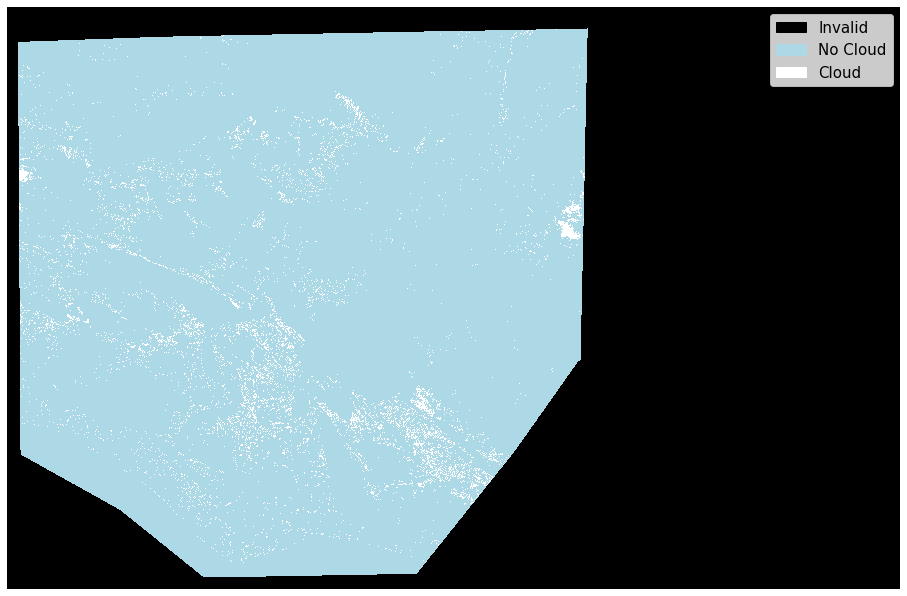

In [22]:
fig, ax = plt.subplots(figsize=(16,16))

im_plt = rasterioplt.show(gt_binary[0],transform=gt_meta_binary["transform"], 
                          interpolation='nearest',ax=ax,
                          cmap=cmap_cat, norm=norm_cat)

ax.legend(
    handles=patches,
    loc='upper right',
    fontsize=15
)
ax.set_axis_off()
plt.show()

In [23]:
COLORS = np.array(
    [[0, 0, 0], # invalid
    [139, 64, 0], # land
    [0, 0, 139]], # water
    dtype=np.float32) / 255

labels = ["Invalid", "Land", "Flood water"]
cmap_cat, norm_cat, patches = plot_utils.get_cmap_norm_colors(COLORS, labels)

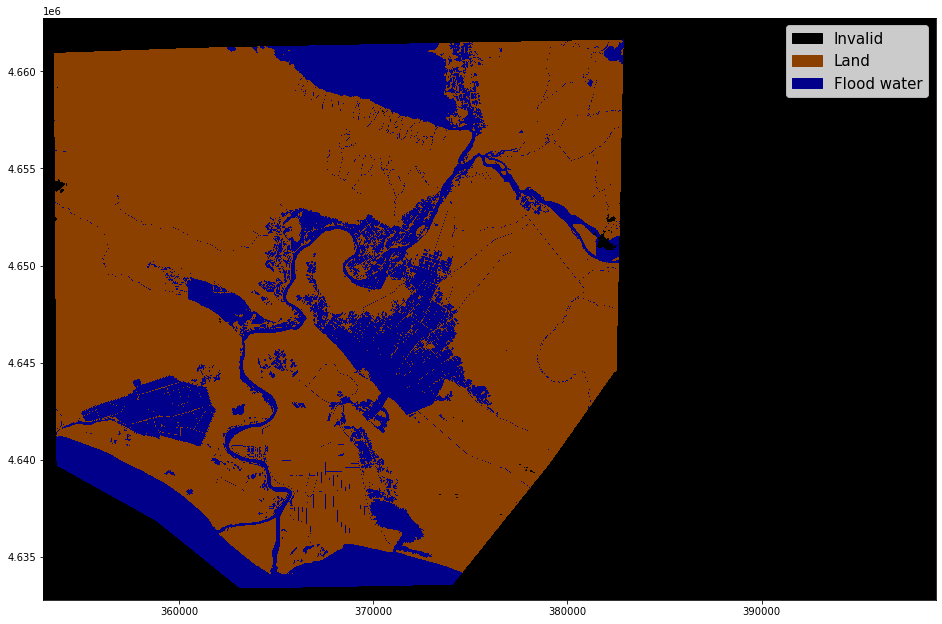

In [24]:
fig, ax = plt.subplots(figsize=(16,16))

im_plt = rasterioplt.show(gt_binary[1],transform=gt_meta_binary["transform"], 
                          interpolation='nearest',ax=ax,
                          cmap=cmap_cat, norm=norm_cat)

ax.legend(
    handles=patches,
    loc='upper right',
    fontsize=15
)